# Statistical Deviation Event Detector

For the eye activation detection task, there is a clear trend in the data - measuring the data with open eyes outputs a clearly different DC Voltage than measuring the data with eyes closed. This can be observed in the sample data below.

### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, welch

In [2]:
#Digilent WaveForms Oscilloscope Acquisition
#Device Name: Discovery2
#Serial Number: SN:210321B5D9FA
#Date Time: 2025-02-13 12:33:16.223
#Sample rate: 136.533Hz
#Samples: 5800
#Trigger: Source: Channel 1 Type: Edge Condition: Rising Level: 0 V Hyst.: Auto HoldOff: 0 s
#Channel 1: Range: 200 mV/div Offset: -2 V Sample Mode: Average
#Channel 2: Range: 500 mV/div Offset: 0 V Sample Mode: Average
#Power Supplies: ON
#Positive Supply: ON
#Voltage: 5 V
#Negative Supply: ON
#Voltage: -5 V

## Statistical Deviation Event Detector Calculations

In [3]:
def apply_sded_fixed(x, eff_dc, alpha, delta):
    meas = np.abs(x - eff_dc)
    alpha_red = alpha/2
    if meas > delta:
        new_eff_dc = alpha_red * x + (1 - alpha_red) * eff_dc
        spike = 1
    else:
        new_eff_dc = alpha * x + (1 - alpha) * eff_dc
        spike = 0
    return new_eff_dc, meas, spike

def apply_sded_adaptive(x, eff_dc, alpha_dc, alpha_delta, delta):
    meas = np.abs(x - eff_dc)
    alpha_dc_red = alpha_dc/2
    alpha_delta_red = alpha_delta/2
    if meas > delta:
        new_delta = np.sqrt(alpha_delta_red * meas**2 + (1 - alpha_delta_red) * delta**2)
        spike = 1
        new_eff_dc = alpha_dc_red * x + (1 - alpha_dc_red) * eff_dc
    else:
        new_delta = np.sqrt(alpha_delta * meas**2 + (1 - alpha_delta) * delta**2)
        spike = 0
        new_eff_dc = alpha_dc * x + (1 - alpha_dc) * eff_dc
    return new_eff_dc, new_delta, meas, spike

def apply_sded_full_fixed_threshold(x, alpha, delta, initial_eff_dc=0):
    eff_dc = np.zeros_like(x)
    eff_dc[0] = initial_eff_dc
    measures = np.zeros_like(x)
    spikes = np.zeros_like(x)
    for i in range(1, len(x)):
        eff_dc[i], measures[i], spikes[i] = apply_sded_fixed(x[i], eff_dc[i-1], alpha, delta)
    return eff_dc, measures, spikes

def apply_sded_full_adaptive_threshold(x, alpha_dc, alpha_delta, delta_0, initial_eff_dc=0):
    eff_dc = np.zeros_like(x)
    eff_dc[0] = initial_eff_dc
    adaptive_delta = np.zeros_like(x)
    adaptive_delta[0] = delta_0
    measures = np.zeros_like(x)
    spikes = np.zeros_like(x)
    for i in range(1, len(x)):
        eff_dc[i], adaptive_delta[i], measures[i], spikes[i] = apply_sded_adaptive(x[i], eff_dc[i-1], alpha_dc, alpha_delta, adaptive_delta[i-1])
    return eff_dc, adaptive_delta, measures, spikes

### SDED Prototype Experiments (Python)

#### SDED Fixed $\delta$

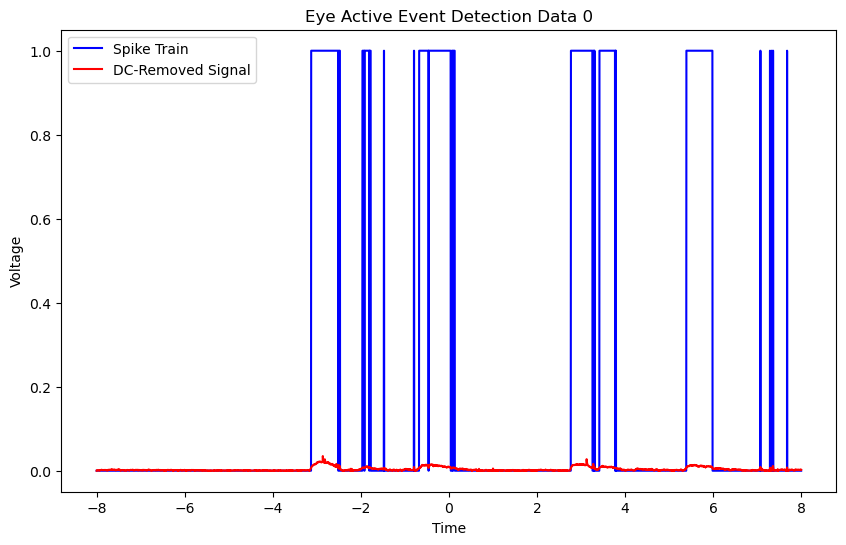

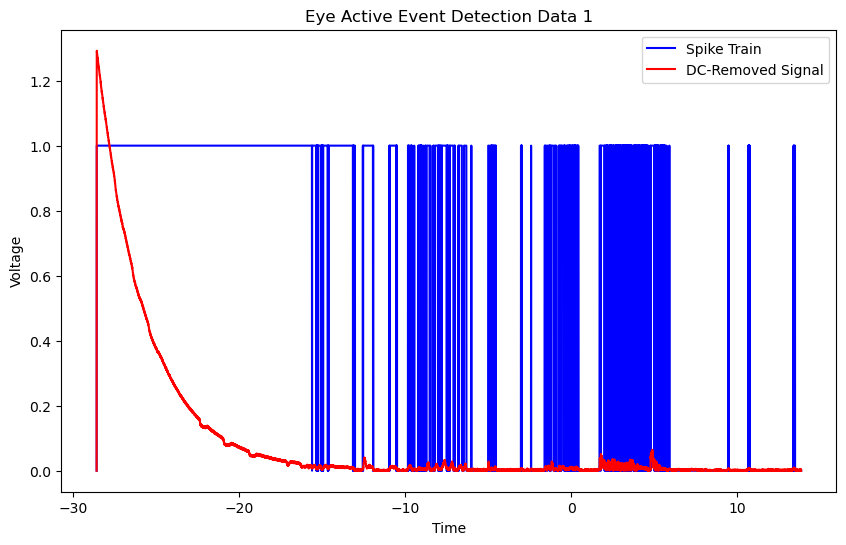

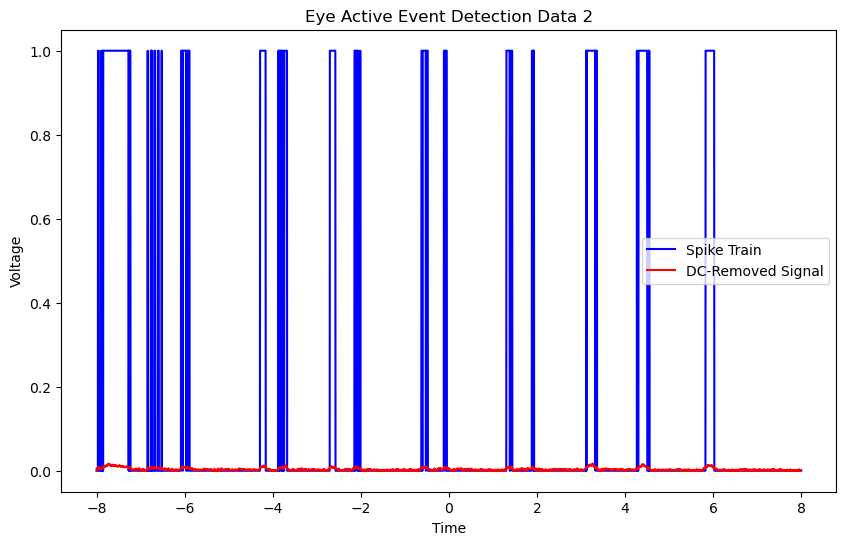

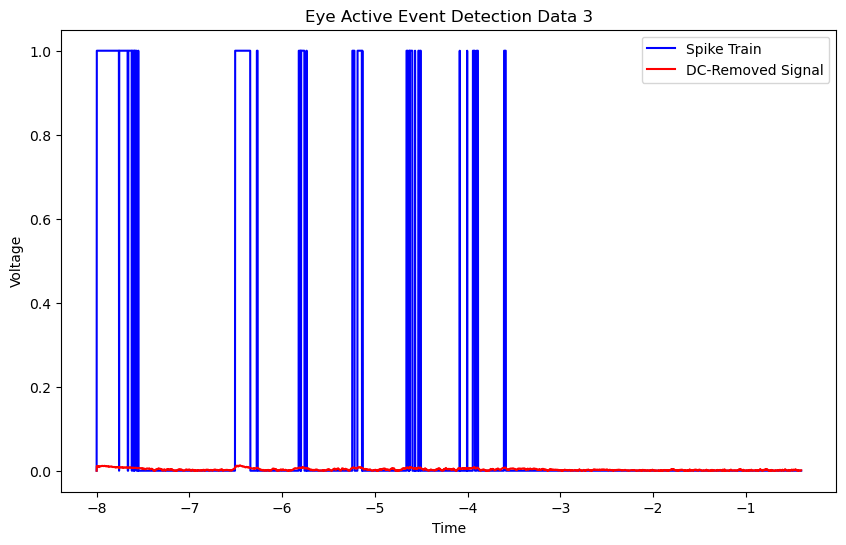

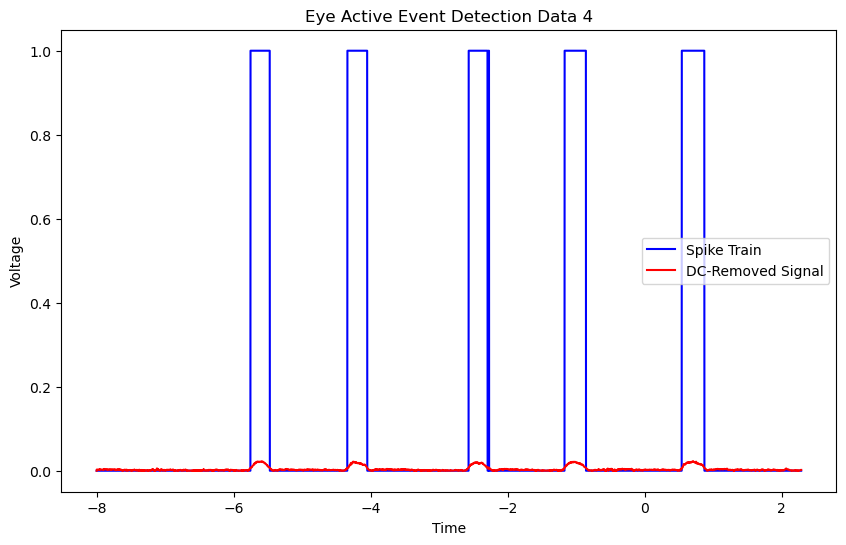

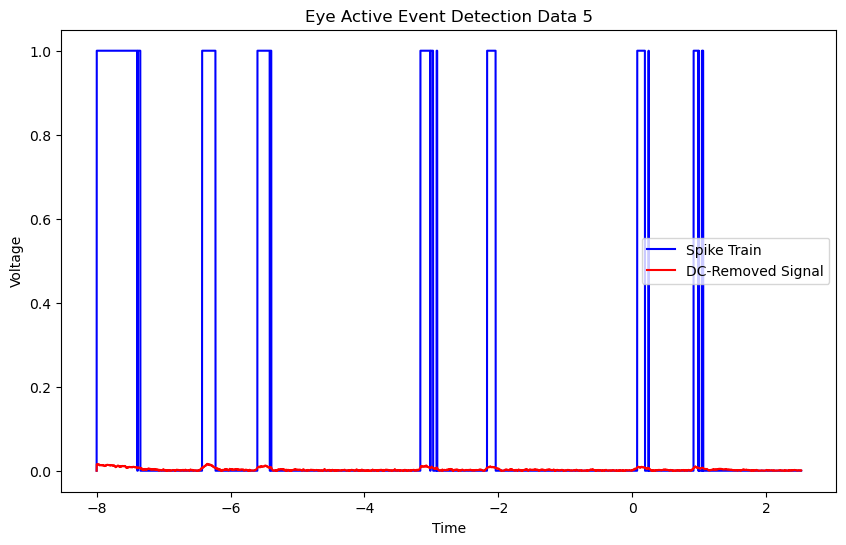

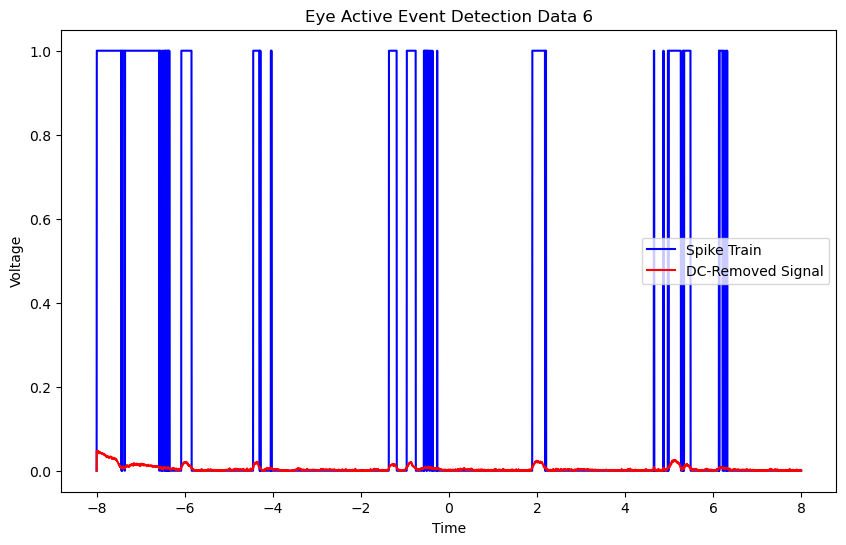

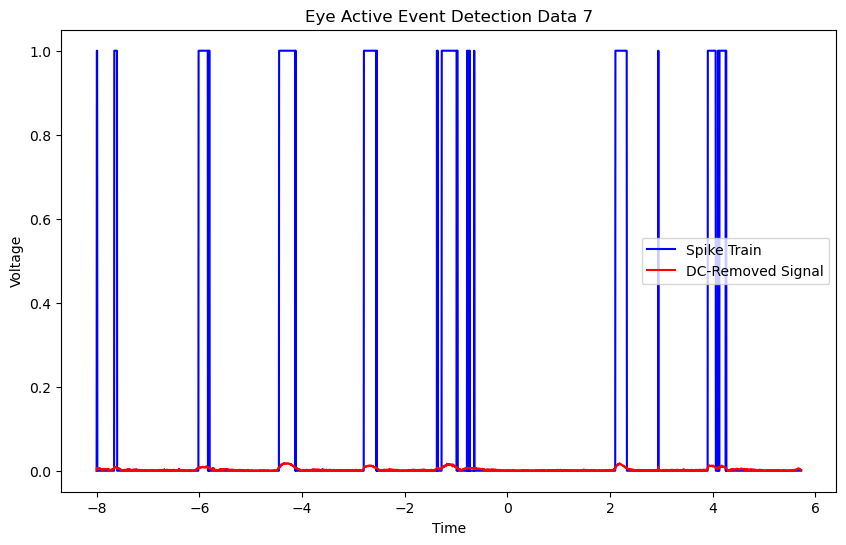

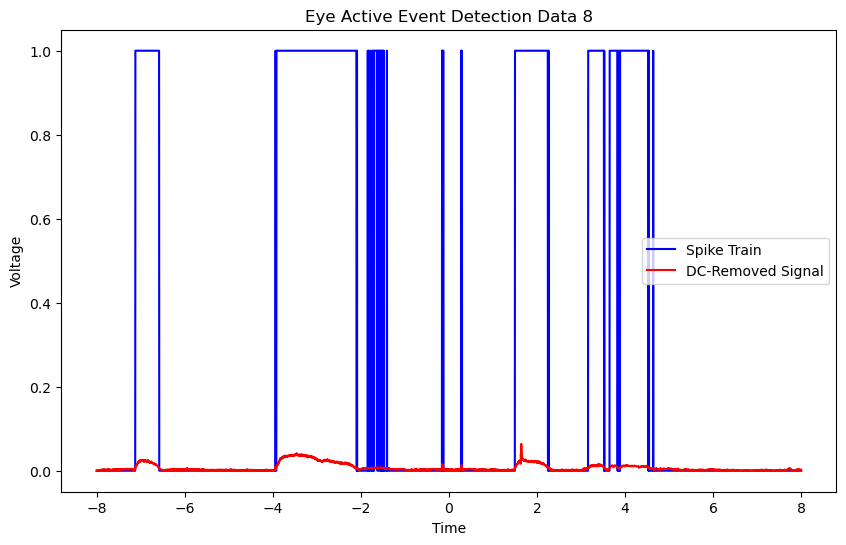

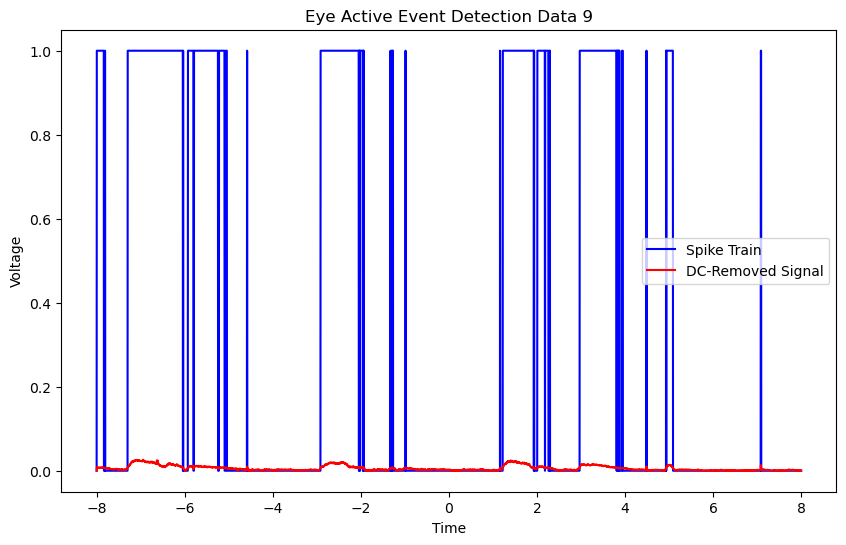

In [4]:
scale = 1.2
deviation = 0.005477277382981891 # Empirically determined standard deviation threshold
delta = scale*deviation # Empirically determined standard deviation threshold
alpha = 0.005
initial_eff_dc = 0.6

avg_std = 0

#for i in range(10):
for i in range(10):
    # Load the data
    data = pd.read_csv(f'eye_blinking{i}.csv', delimiter=',')
    # Drop Channel2
    data = data.drop(columns=['Channel2'])
    voltage = data['Channel1']
    time = data['Time']
    N = len(voltage)
    # Apply the filter
    _, dc_removed_voltage, spike_train = apply_sded_full_fixed_threshold(voltage, alpha, delta, initial_eff_dc)

    # Plot the event detection
    plt.figure(figsize=(10, 6))
    plt.plot(time, spike_train, 'b', label='Spike Train')
    plt.plot(time, dc_removed_voltage, 'r', label='DC-Removed Signal')
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Voltage')
    plt.title(f'Eye Active Event Detection Data {i}')
    plt.show()


#### SDED Adaptive $\delta$

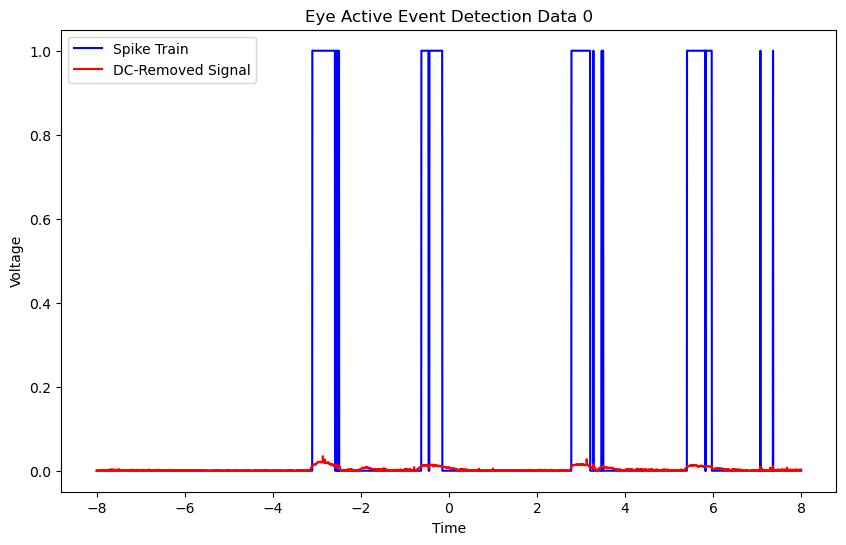

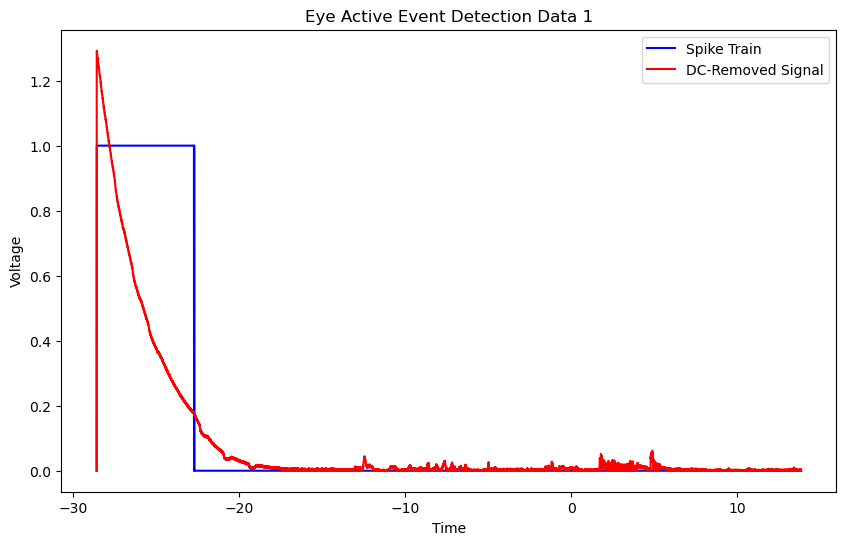

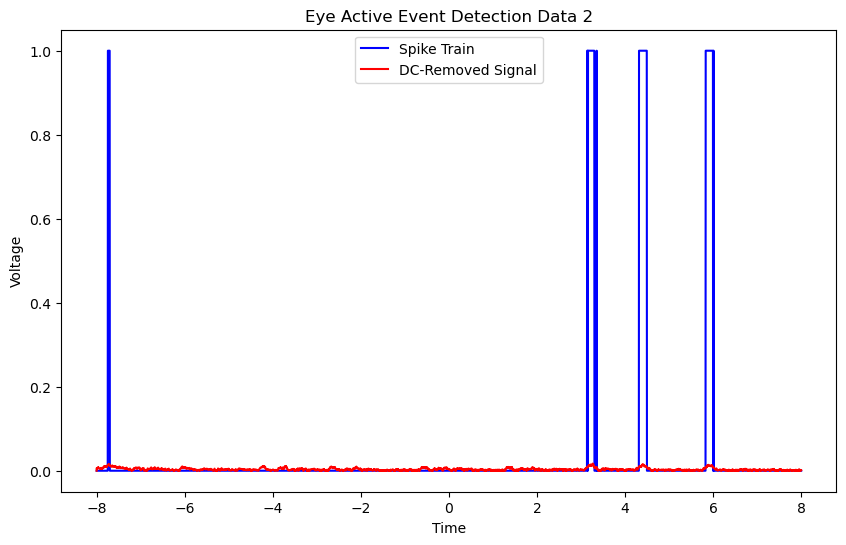

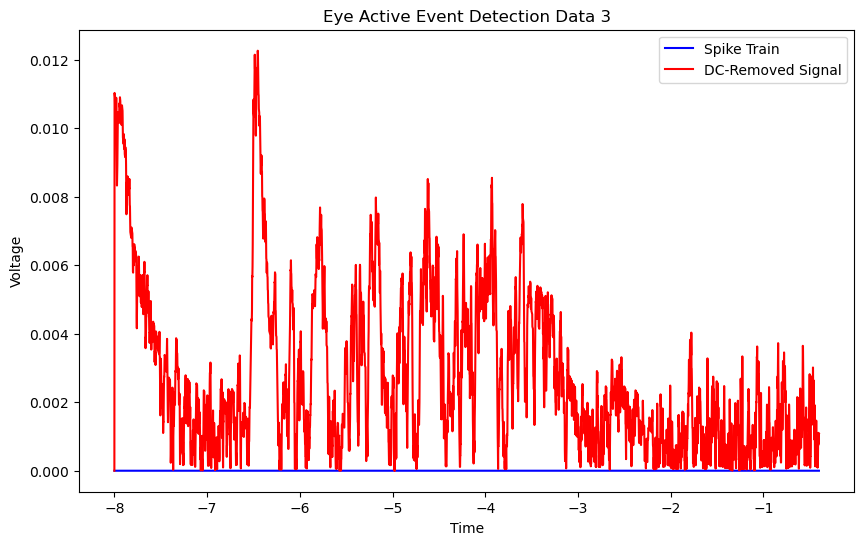

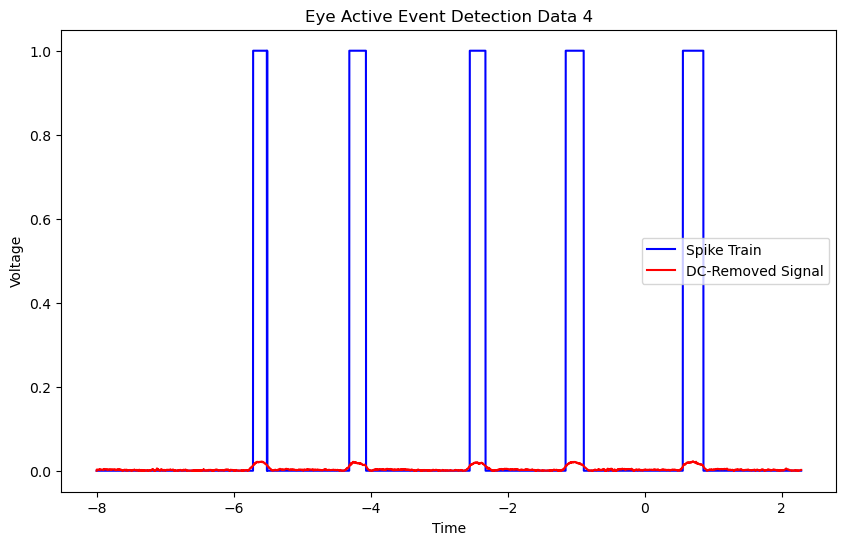

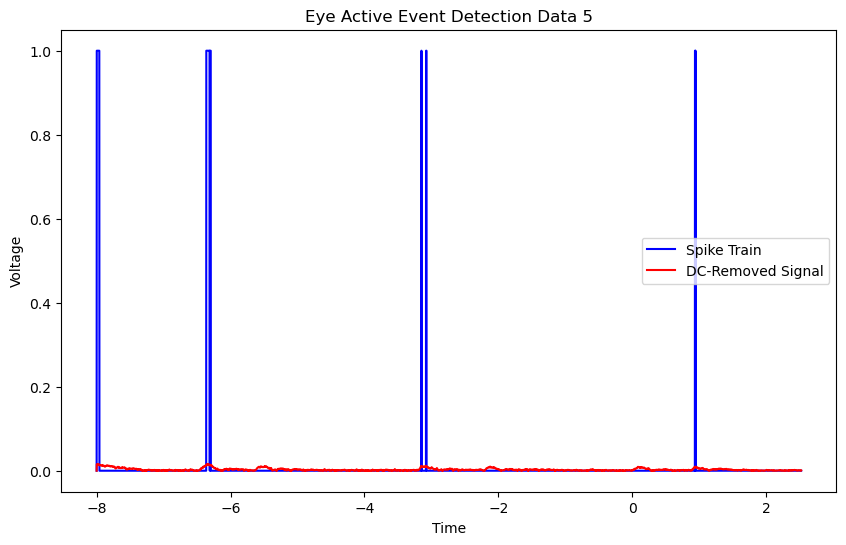

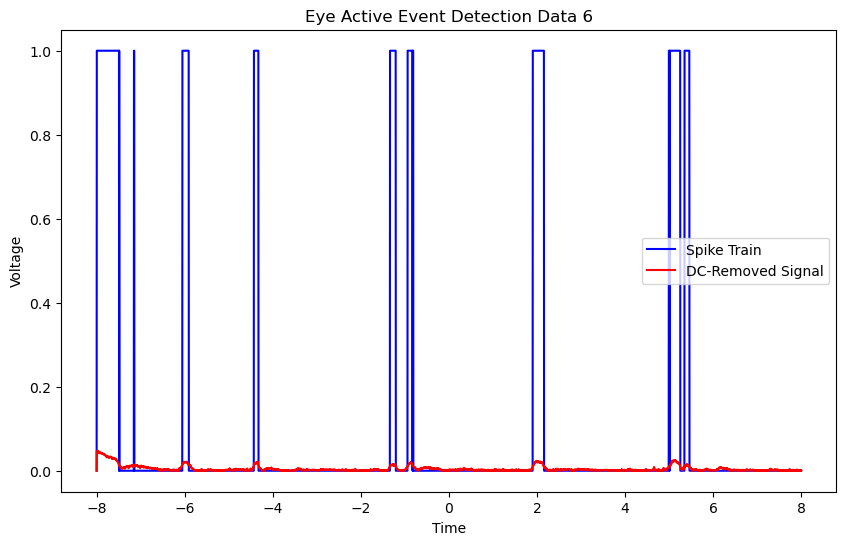

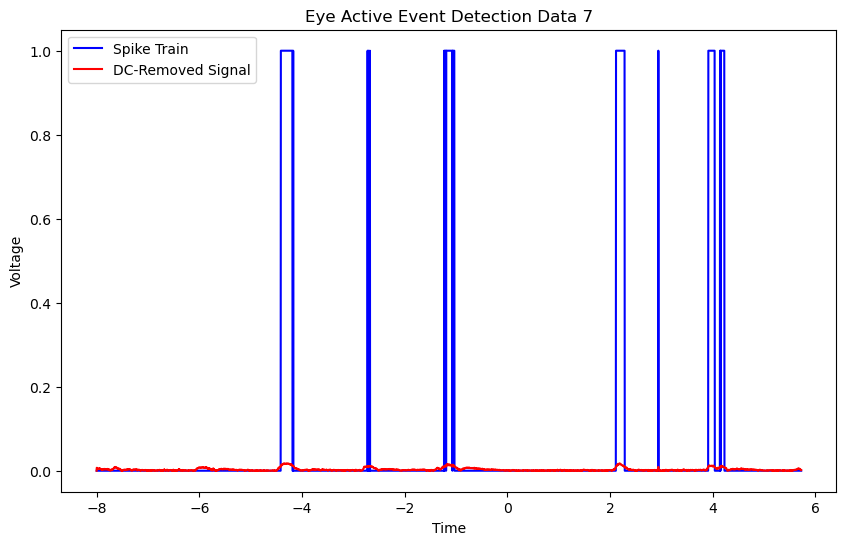

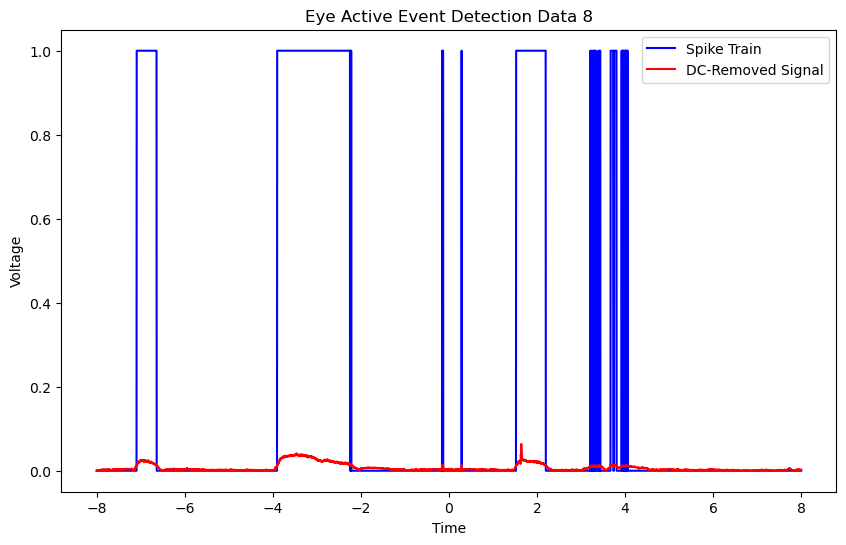

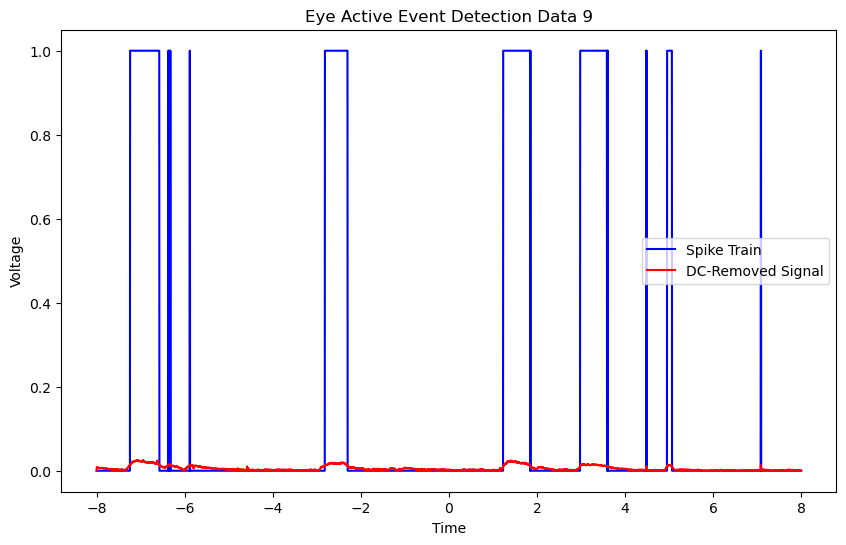

In [5]:
scale = 2.5
deviation = 0.005477277382981891 # Empirically determined standard deviation threshold
delta = scale*deviation # Empirically determined standard deviation threshold
alpha_dc = 0.005
alpha_delta = 0.0002
initial_eff_dc = 0.6

avg_std = 0

#for i in range(10):
for i in range(10):
    # Load the data
    data = pd.read_csv(f'eye_blinking{i}.csv', delimiter=',')
    # Drop Channel2
    data = data.drop(columns=['Channel2'])
    voltage = data['Channel1']
    time = data['Time']
    N = len(voltage)
    # Apply the filter
    _, _, dc_removed_voltage, spike_train = apply_sded_full_adaptive_threshold(voltage, alpha_dc, alpha_delta, delta, initial_eff_dc)

    # Plot the event detection
    plt.figure(figsize=(10, 6))
    plt.plot(time, spike_train, 'b', label='Spike Train')
    plt.plot(time, dc_removed_voltage, 'r', label='DC-Removed Signal')
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Voltage')
    plt.title(f'Eye Active Event Detection Data {i}')
    plt.show()

### SDED Evaluation Experiment (C)

To use the C code, download the SDED.C file, and compile with the corresponding compiler. For Linux, the command:
```
gcc SDED.C -o sded -lm
./sded
```

Can validate the results obtained above on your own dataset. For real-time functions, the ```apply_sded``` function should be used in an online-fashion. This means, it can and should be used per input received.

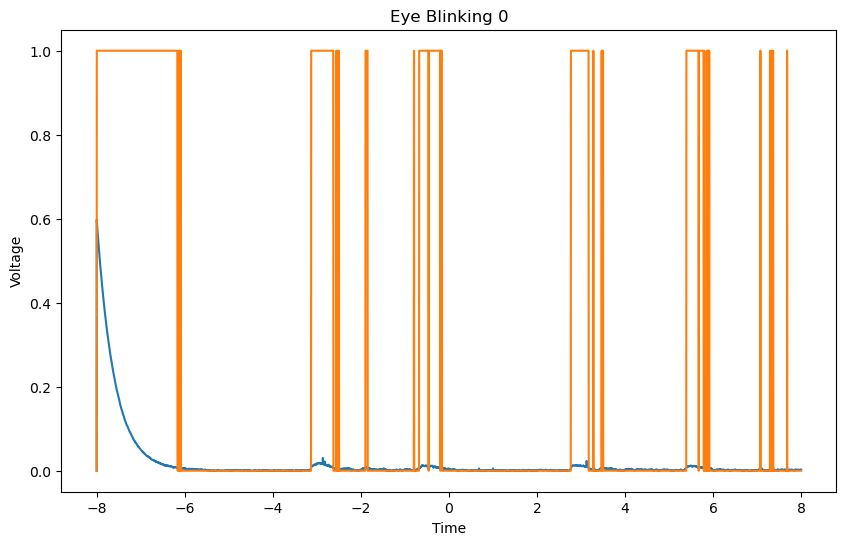

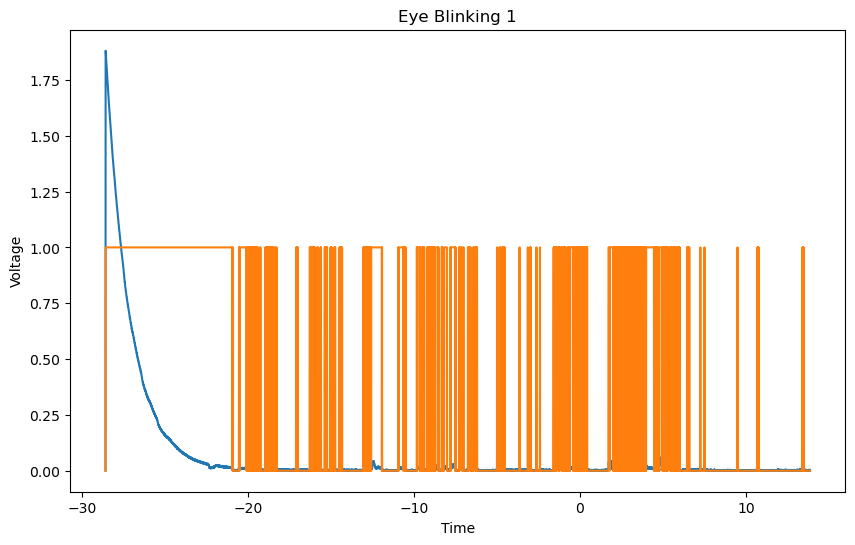

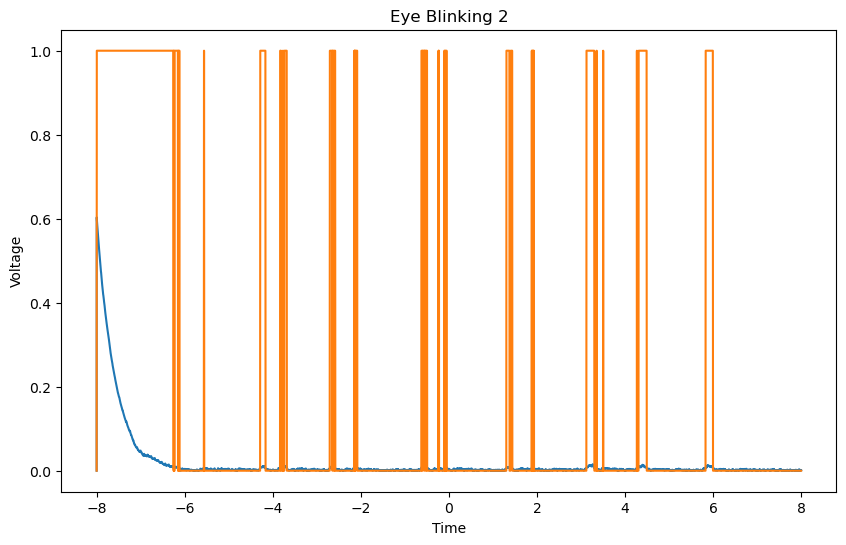

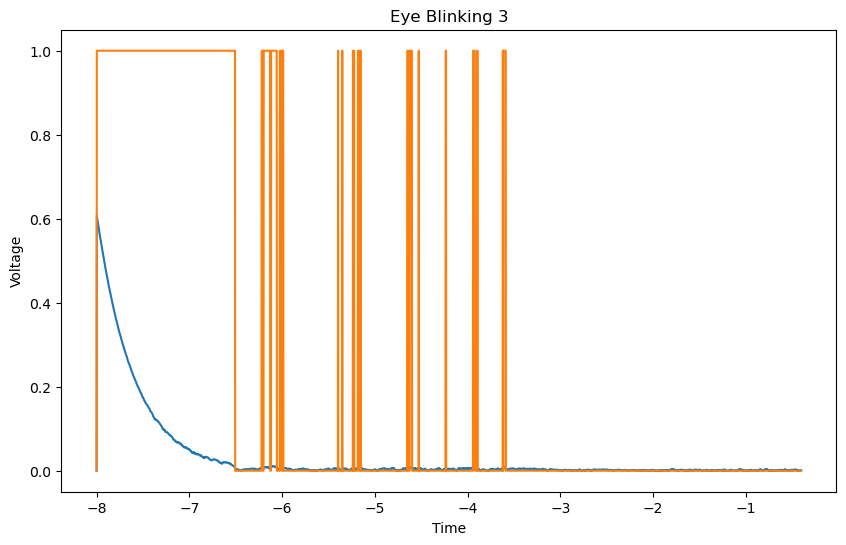

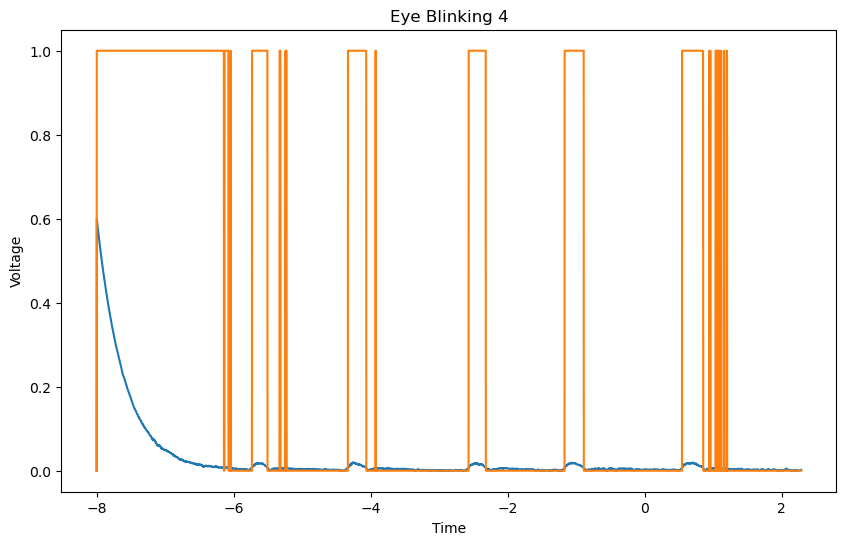

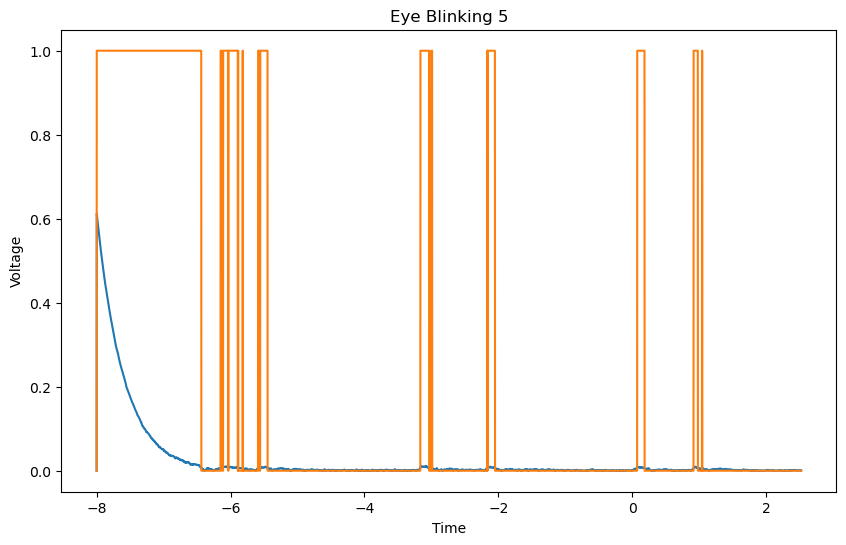

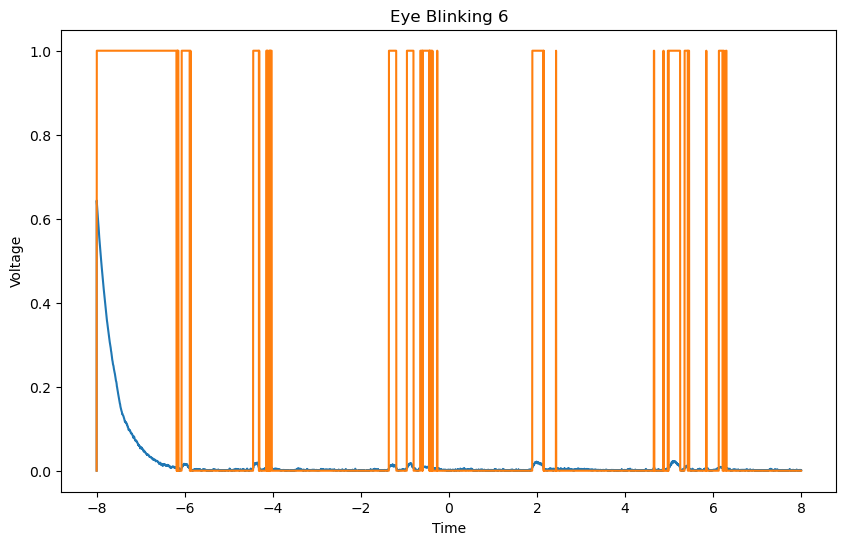

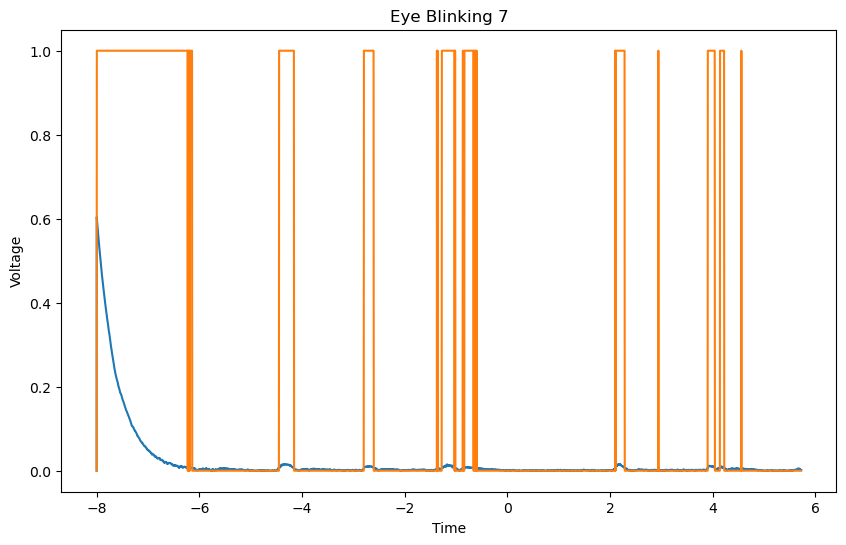

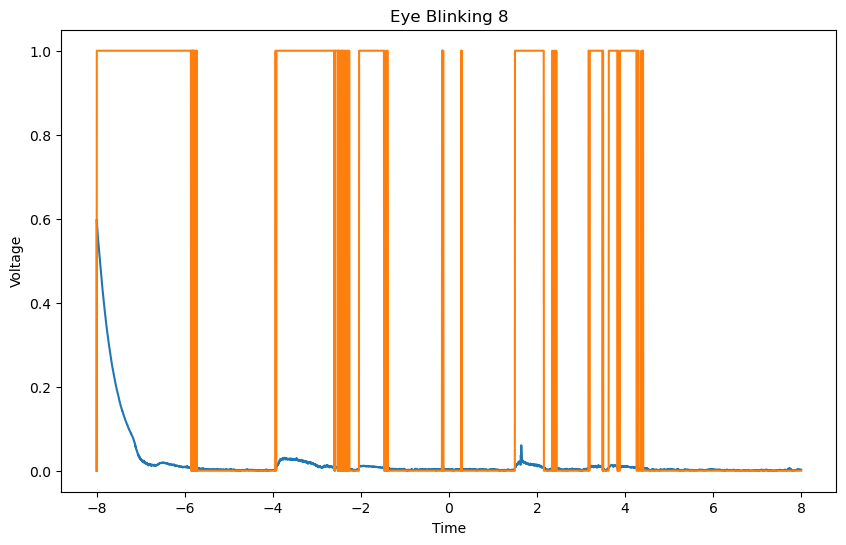

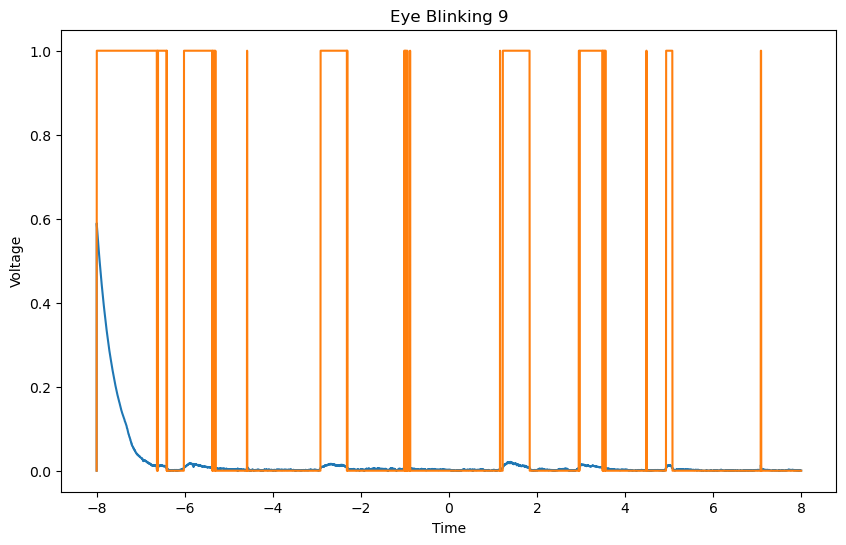

In [6]:
for i in range(10):
    data = pd.read_csv(f'output{i}.csv', delimiter=',')

    plt.figure(figsize=(10, 6))
    plt.plot(data['Time'], data['DC_Removed'])
    plt.plot(data['Time'], data['Spike'])

    plt.title(f'Eye Blinking {i}')
    plt.xlabel('Time')
    plt.ylabel('Voltage')
    plt.title(f'Eye Blinking {i}')
    plt.show()
